In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pharma-sales-data/salesdaily.csv
/kaggle/input/pharma-sales-data/salesweekly.csv
/kaggle/input/pharma-sales-data/salesmonthly.csv
/kaggle/input/pharma-sales-data/saleshourly.csv


## **Import Libraries**

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# from keras.models import Sequential
# from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, roc_curve, auc, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

from datetime import datetime
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

2024-04-11 14:49:36.889994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 14:49:36.890128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 14:49:37.051292: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
salesdaily=pd.read_csv('/kaggle/input/pharma-sales-data/salesdaily.csv')
saleshourly=pd.read_csv('/kaggle/input/pharma-sales-data/saleshourly.csv')
salesmonthly=pd.read_csv('/kaggle/input/pharma-sales-data/salesmonthly.csv')
salesweekly=pd.read_csv('/kaggle/input/pharma-sales-data/salesweekly.csv')

In [4]:
salesdaily.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday
3,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday
4,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday


In [5]:
saleshourly.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014 8:00,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,1/2/2014 9:00,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,1/2/2014 10:00,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday
3,1/2/2014 11:00,0.0,0.00,0.0,2.0,1.0,0.0,0.0,0.0,2014,1,11,Thursday
4,1/2/2014 12:00,0.0,2.00,0.0,5.0,2.0,0.0,0.0,0.0,2014,1,12,Thursday


In [6]:
salesweekly.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,1/12/2014,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,1/19/2014,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,1/26/2014,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2/2/2014,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


In [7]:
salesmonthly.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


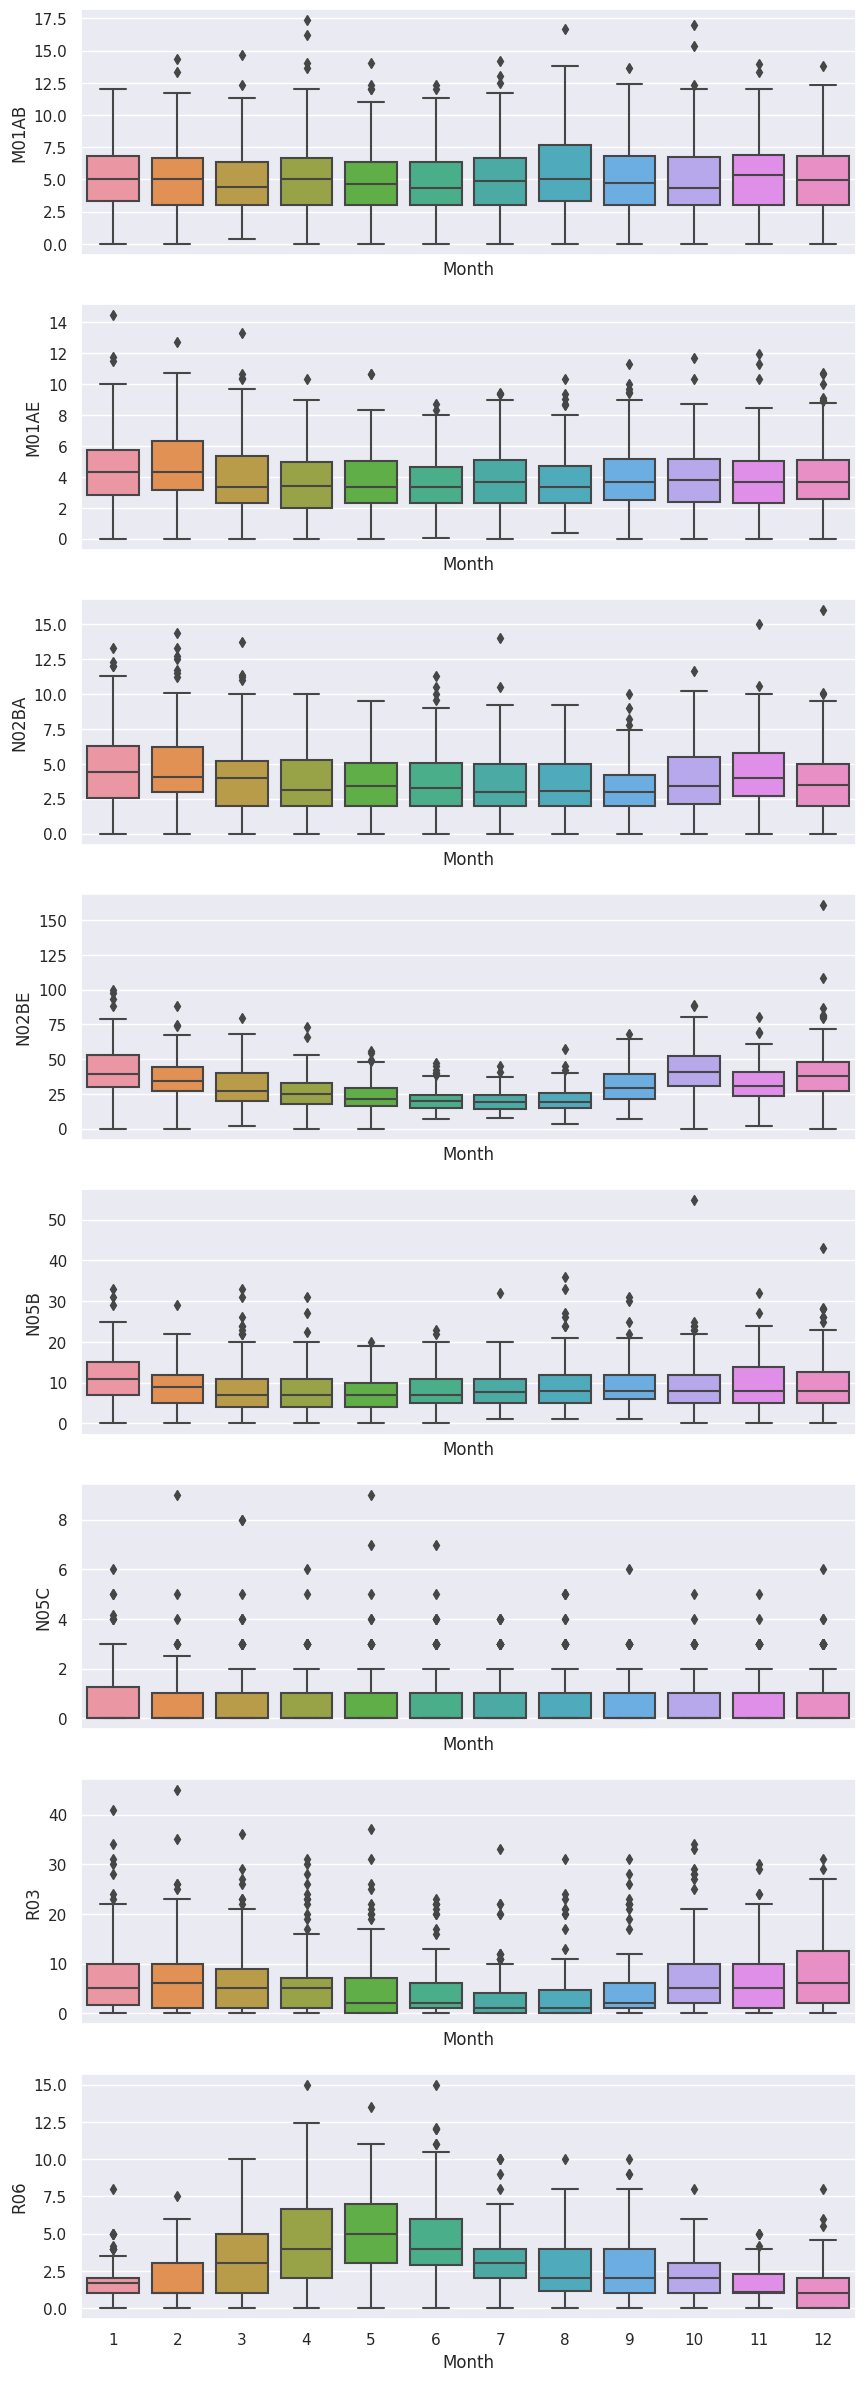

In [8]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=salesdaily, x='Month', y=name, ax=ax)

## **Load Data**

In [9]:
data = pd.read_csv('/kaggle/input/pharma-sales-data/salesmonthly.csv')

## **Data Preprocessing**

In [10]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 datum    0
M01AB    0
M01AE    0
N02BA    0
N02BE    0
N05B     0
N05C     0
R03      0
R06      0
dtype: int64


In [11]:
atc_categories = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
category_sales = {}
for category in atc_categories:
    category_sales[category] = data.groupby(category).sum()

In [12]:
data.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


In [13]:
data.shape

(70, 9)

In [14]:
# Assuming 'salesdaily' is your DataFrame and 'datum' column contains dates as strings
salesmonthly['datum'] = pd.to_datetime(salesmonthly['datum'])

In [15]:
salesmonthly

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.20
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.20
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.40
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.70
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.70
...,...,...,...,...,...,...,...,...,...
65,2019-06-30,151.54,101.627,103.200,610.000,193.0,25.0,142.0,156.04
66,2019-07-31,181.00,103.541,92.800,649.800,250.6,20.0,115.0,105.20
67,2019-08-31,181.91,88.269,84.200,518.100,237.0,26.0,145.0,97.30
68,2019-09-30,161.07,111.437,93.500,984.480,227.8,16.0,161.0,109.10


In [16]:
print(salesmonthly['datum'].min())
print(salesmonthly['datum'].max())

2014-01-31 00:00:00
2019-10-31 00:00:00


In [17]:
# Reshape the dataframe
salesmonthly_new = salesmonthly.melt(id_vars=['datum'],
             var_name='Drug',
             value_name='Quantity')

# Print the updated dataframe
salesmonthly_new

,datum,Drug,Quantity
0,2014-01-31,M01AB,127.69
1,2014-02-28,M01AB,133.32
2,2014-03-31,M01AB,137.44
3,2014-04-30,M01AB,113.10
4,2014-05-31,M01AB,101.79
...,...,...,...
555,2019-06-30,R06,156.04
556,2019-07-31,R06,105.20
557,2019-08-31,R06,97.30
558,2019-09-30,R06,109.10


In [18]:
import plotly.express as px

# Plot the graph on drug basis
fig = px.line(salesmonthly_new, x='datum', y='Quantity', color='Drug', 
              title='Monthly Sales Quantity of Drugs', labels={'datum': 'Date', 'Quantity': 'Sales Quantity'})

# Show the plot
fig.show()

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [20]:
# salesmonthly_new['datum'] = le.fit_transform(salesmonthly_new['datum'])
salesmonthly_new['Drug'] = le.fit_transform(salesmonthly_new['Drug'])
salesmonthly_new

,datum,Drug,Quantity
0,2014-01-31,0,127.69
1,2014-02-28,0,133.32
2,2014-03-31,0,137.44
3,2014-04-30,0,113.10
4,2014-05-31,0,101.79
...,...,...,...
555,2019-06-30,7,156.04
556,2019-07-31,7,105.20
557,2019-08-31,7,97.30
558,2019-09-30,7,109.10


In [21]:
# Create a new index column
salesmonthly_new['Index'] = range(len(salesmonthly_new))

# Set 'Index' as the index
salesmonthly_new.set_index('Index', inplace=True)

In [22]:
salesmonthly_new

,datum,Drug,Quantity
Index,,,
0,2014-01-31,0,127.69
1,2014-02-28,0,133.32
2,2014-03-31,0,137.44
3,2014-04-30,0,113.10
4,2014-05-31,0,101.79
...,...,...,...
555,2019-06-30,7,156.04
556,2019-07-31,7,105.20
557,2019-08-31,7,97.30


## **Model Fitting**

In [23]:
# Function to prepare data
def prepare_data(time_data, n_features):
    X, y = [], []
    for i in range(len(time_data)):
        end_ix = i + n_features
        if end_ix > len(time_data) - 1:
            break
        X.append(time_data[i:end_ix])
        y.append(time_data[end_ix])
    return np.array(X), np.array(y)

In [24]:
# Splitting data into train and test sets
split_index = 550
train = salesmonthly_new.iloc[:split_index]
test = salesmonthly_new.iloc[split_index:]

In [25]:
# Extract features and target
X_train = train.drop(['datum'], axis=1).values
y_train = train['Quantity'].values
X_test = test.drop(['datum'], axis=1).values
y_test = test['Quantity'].values

In [26]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# Normalize target variable
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [28]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [29]:
# Define the LSTM model architecture
def create_lstm_model(input_shape, n_units=256, n_layers=3, dropout_rate=0.3):
    model = Sequential()
    for i in range(n_layers):
        model.add(LSTM(units=n_units, activation='relu', return_sequences=True if i < n_layers - 1 else False,
                       input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Output layer
    return model

# Create the LSTM model
n_features = X_train.shape[1]
input_shape = (n_features, 1)
model = create_lstm_model(input_shape)

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2, 256)         │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 2, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,318,145 (5.03 MB)

 Trainable params: 1,316,609 (5.02 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 1.9395 - val_loss: 0.6412 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.2937 - val_loss: 0.6184 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.0894 - val_loss: 0.5993 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.9627 - val_loss: 0.5745 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.9152 - val_loss: 0.5490 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0548 - val_loss: 0.5477 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.9801 - val_loss: 0.5468 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.7836 - val_loss: 0.5354 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7354 - val_loss: 0.5352 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━

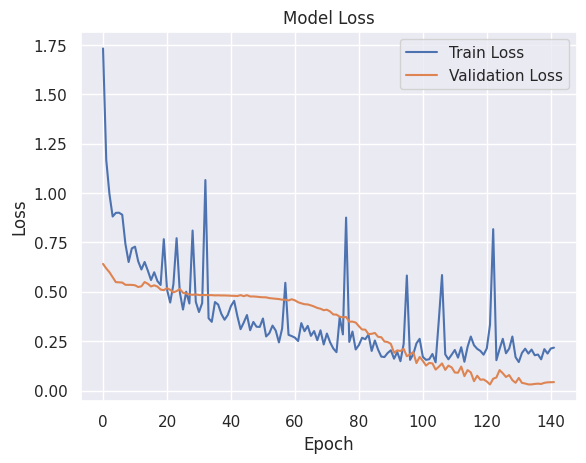

In [31]:
# Compile the model
model.compile(optimizer='adam', loss='mae')

# Early stopping and learning rate reduction to prevent overfitting
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
train_mae = np.mean(np.abs(model.predict(X_train) - y_train))
val_mae = np.mean(np.abs(model.predict(X_val) - y_val))

print('Train Loss:', train_loss)
print('Validation Loss:', val_loss)
print('Train MAE:', train_mae)
print('Validation MAE:', val_mae)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
### Evaluate the model on the training set
train_loss = model.evaluate(X_train, y_train, verbose=0)
train_predictions = model.predict(X_train)
train_mae = np.mean(np.abs(train_predictions - y_train))
train_mse = np.mean((train_predictions - y_train)**2)
train_rmse = np.sqrt(train_mse)

# Evaluate the model on the validation set
val_loss = model.evaluate(X_val, y_val, verbose=0)
val_predictions = model.predict(X_val)
val_mae = np.mean(np.abs(val_predictions - y_val))
val_mse = np.mean((val_predictions - y_val)**2)
val_rmse = np.sqrt(val_mse)

print('Train Loss:', train_loss)
print('Train MAE:', train_mae)
print('Train MSE:', train_mse)
print('Train RMSE:', train_rmse)

print('Validation Loss:', val_loss)
print('Validation MAE:', val_mae)
print('Validation MSE:', val_mse)
print('Validation RMSE:', val_rmse)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Train Loss: 0.033557239919900894
Train MAE: 0.8970852969456817
Train MSE: 2.2739438601166344
Train RMSE: 1.5079601652950367
Validation Loss: 0.03153060004115105
Validation MAE: 0.7341676848140153
Validation MSE: 1.553493535578743
Validation RMSE: 1.2463922077655745


## **Forecasting**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


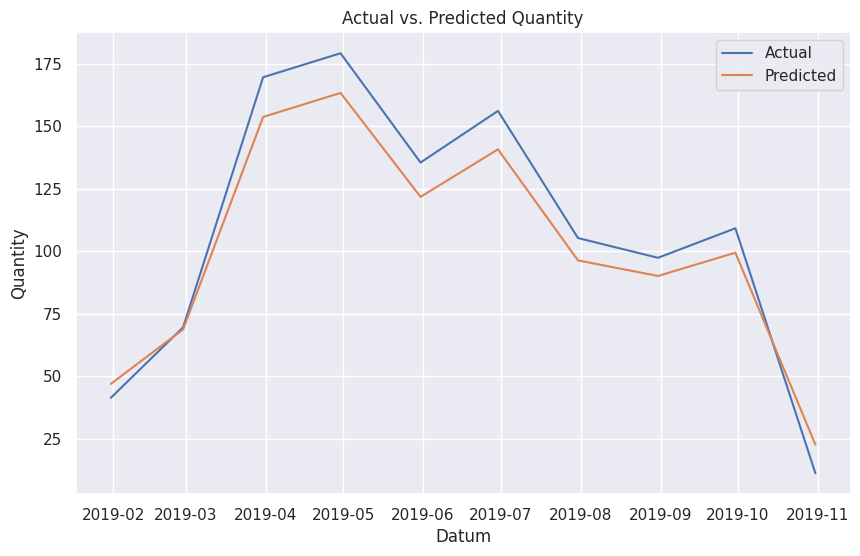

In [33]:
import matplotlib.pyplot as plt

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predicted values
predictions_inv = scaler_y.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Inverse transform the test labels for comparison
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(salesmonthly_new['datum'][split_index:], y_test_inv, label='Actual')
plt.plot(salesmonthly_new['datum'][split_index:], predictions_inv, label='Predicted')
plt.title('Actual vs. Predicted Quantity')
plt.xlabel('Datum')
plt.ylabel('Quantity')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

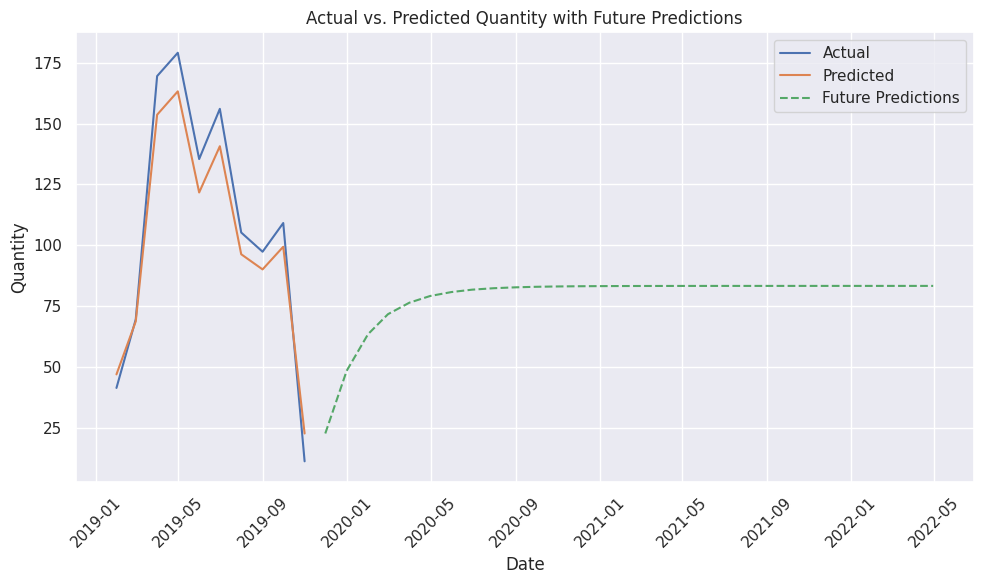

In [34]:
# Number of future time steps to predict
future_steps = 30  # Adjust as needed

# Prepare the last window of data from the test set to predict future values
last_window = X_test[-1].reshape(1, -1)  # Reshape to match model input shape

# Predict future values iteratively
future_predictions = []
for _ in range(future_steps):
    # Predict the next value
    next_pred = model.predict(last_window)
    
    # Append the prediction to the list
    future_predictions.append(next_pred[0])
    
    # Update the last window by removing the first element and adding the prediction
    last_window = np.roll(last_window, -1)
    last_window[-1] = next_pred

# Inverse transform the predicted future values
future_predictions = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Generate future dates for plotting
last_date = pd.to_datetime(salesmonthly_new['datum'].iloc[-1])
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1, future_steps + 1)]

# Plot actual vs. predicted values with future predictions
plt.figure(figsize=(10, 6))
plt.plot(salesmonthly_new['datum'][split_index:], y_test_inv, label='Actual')
plt.plot(salesmonthly_new['datum'][split_index:], predictions_inv, label='Predicted')
plt.plot(future_dates, future_predictions, label='Future Predictions', linestyle='--')
plt.title('Actual vs. Predicted Quantity with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()